In [1]:
import csv, librosa, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = "/home/bhm-ai/music_classification"
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
songname = f'{path}/Data/genres_original/jazz/jazz.00029.wav'

# header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
header = 'filename chroma_stft_mean chroma_stft_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var'
for i in range(1, 21):
    header += f' mfcc{i}_mean mfcc{i}_var'
header += ' label'
header = header.split()

demo = False  
pre_dataset = True
epochs = 900 if not demo else 5
# epochs = 600 if not demo else 5

converter = LabelEncoder()

2024-06-18 10:19:39.178325: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 10:19:39.182822: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 10:19:39.233158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 10:19:40.018808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Training the model using the following parameters
# metrics = accuracy
# epochs = 600
# loss = sparse_categorical_crossentropy
# batch_size = 256
# optimizer = adam

def train_model(model,epochs,optimizer):
    batch_size=256
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

def Validation_plot(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

def readdata(df):
    df = df.drop(labels="filename",axis=1)
    
    fit = StandardScaler()
    X = fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))
    return X, df

def extractfeature(y, sr, filename='_', g='_'):  # 60 columns; missing rms, harmony, perceptr, tempo

    def compose(*fs):  # https://github.com/numpy/numpy/issues/12579
        def wrapped(x):
            for f in fs[::-1]:
                x = f(x)
            return x
        return wrapped    
    rms = compose(np.sqrt, np.mean, np.square)
    rms_ = rms(y)

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{filename} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.mean(rms_)} {np.var(rms_)} {np.mean(spec_cent)} {np.var(spec_cent)} {np.mean(spec_bw)} {np.var(spec_bw)} {np.mean(rolloff)} {np.var(rolloff)} {np.mean(zcr)} {np.var(zcr)}'
    for e in mfcc:
        to_append += f' {np.mean(e)} {np.var(e)}'
    to_append += f' {g}'
    return to_append



def extractfeature_(y, sr, filename='_', g='_'):  # 27 columns 
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    to_append += f' {g}'
    return to_append


def big_cnn_model(train=True):
    # https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model
    if not train:
        model = tf.keras.models.load_model("model.keras")
    else:
        # We used different layers to train the neural network by importing keras library from tensorflow framework 
        # for input and hidden neurons we use the most widly used activation function which is relu where as for output neurons we uses softmax activation function
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(256,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(64,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(32,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            
            tf.keras.layers.Dense(10,activation='softmax'),
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.000146)
        model.compile(optimizer=optimizer,
                     loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        model.summary()
        model_history=train_model(model=model, epochs=epochs, optimizer='adam')
        
        test_loss,test_acc=model.evaluate(X_test,y_test,batch_size=256)
        print("The test loss is ",test_loss)
        print("The best accuracy is: ",test_acc*100)
        
        Validation_plot(model_history)
        model.save("model.keras")
    return model


def cnn_model(train=True):
    # https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model
    if not train:
        model = tf.keras.models.load_model("model.keras")
    else:
        # We used different layers to train the neural network by importing keras library from tensorflow framework 
        # for input and hidden neurons we use the most widly used activation function which is relu where as for output neurons we uses softmax activation function
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.000146)
        model.compile(optimizer=optimizer,
                     loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        model.summary()
        model_history=train_model(model=model, epochs=epochs, optimizer='adam')
        
        test_loss,test_acc=model.evaluate(X_test,y_test,batch_size=256)
        print("The test loss is ",test_loss)
        print("The best accuracy is: ",test_acc*100)
        
        Validation_plot(model_history)
        model.save("model.keras")
    return model

## tiền xử lí dữ liệu 

In [3]:
def predat_():
    return pd.read_csv(path + "/Data/features_3_sec.csv")

def predat():
    if pre_dataset:
        file = open(f'{path}/try_running__features_3_sec.csv', 'w', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(header)
        genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
        for g in genres:
            ldir = list(os.listdir(f'{path}/Data/genres_original/{g}'))
            listfn = ldir[:5] if demo else ldir
            for filename in listfn:
                songname = f'{path}/Data/genres_original/{g}/{filename}'
                y, sr = librosa.load(songname, mono=True, duration=30)
                to_append = extractfeature(y, sr, filename, g)
                file = open(f'{path}/try_running__features_3_sec.csv', 'a', newline='')
                with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())
    return pd.read_csv(f"{path}/try_running__features_3_sec.csv")

df = predat_()
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [4]:
print("Columns containing missing values",list(df.columns[df.isnull().any()]))

 # Label Encoding - encod the categorical classes with numerical integer values for training

# Blues - 0
# Classical - 1
# Country - 2
# Disco - 3
# Hip-hop - 4 
# Jazz - 5  
# Metal - 6 
# Pop - 7
# Reggae - 8
# Rock - 9
class_encod = df.iloc[:,-1]
Y = converter.fit_transform(class_encod)

X, df = readdata(df)
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.3)

Columns containing missing values []


## CNN model

/home/bhm-ai/music_classification/venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-06-18 10:19:41.193449: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 58)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 58)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        30,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,098 (801.16 KB)

 Trainable params: 205,098 (801.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/900
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1719 - loss: 2.2203 - val_accuracy: 0.4047 - val_loss: 1.6870
Epoch 2/900
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3894 - loss: 1.7688 - val_accuracy: 0.5506 - val_loss: 1.3530
Epoch 3/900
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4618 - loss: 1.5589 - val_accuracy: 0.6180 - val_loss: 1.1468
Epoch 4/900
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5150 - loss: 1.4000 - val_accuracy: 0.6567 - val_loss: 1.0247
Epoch 5/900
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5513 - loss: 1.2999 - val_accuracy: 0.6967 - val_loss: 0.9334
Epoch 6/900
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5819 - loss: 1.2415 - val_accuracy: 0.6944 - val_loss: 0.8947
Epoch 7/900
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6071 - loss: 1.1591 - val_accuracy: 0.7344 - val_loss: 0.8238
Epoch 8/900
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6302 - loss: 1.0887 - val_accuracy: 0.

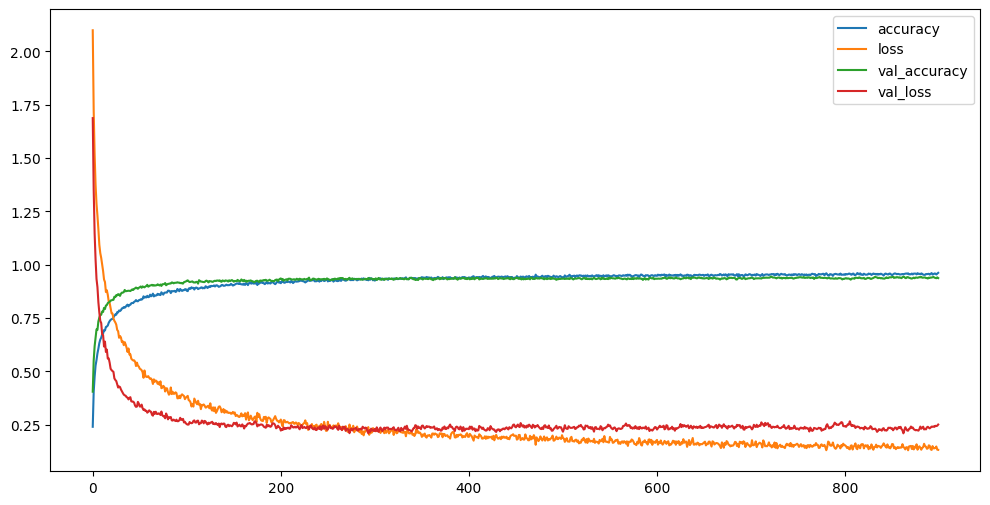

In [5]:
# model = cnn_model(True)  # cnn_model(False)
model = big_cnn_model(True)  # big_cnn_model(False)

trích xuất đặc trưng, lưu vào csv  # reference more at https://github.com/danyalimran93/Music-Emotion-Recognition/blob/master/Feature-Extraction.py

In [6]:
file = open('try_running__Extracted___Data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

y, sr = librosa.load(songname, mono=True, duration=30)
to_append = extractfeature(y, sr, filename='_', g='_')

In [7]:
file = open('try_running__Extracted___Data.csv', 'a', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(to_append.split())

df = pd.read_csv('try_running__Extracted___Data.csv')
df.head()

# # assert len(list(df.columns[df.isnull().any()])) > 0
X, df = readdata(df)
pred_x = model.predict(X)
pred_ind = np.argmax(pred_x, axis=1)
# print(labels[pred_ind])
print(converter.inverse_transform(pred_ind)[:1])


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 58, but received input with shape (1, 25)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 25), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# print(pred_ind)
# print(class_encod)